# 测试新添加的singlefunction,couplefunction,signleNfunction效果

In [18]:
import pandas as pd
import geppy as gep
from deap import creator, base, tools, gp
import numpy as np
import random
import operator
from time import time
import math
import os
from inspect import getmembers, isfunction
from ALLfunctions import singlefunction,couplefunction,singleNfunction
import globalVars
import warnings
warnings.filterwarnings("ignore")

# 读取数据

In [19]:
#########数据读取#####################
data = pd.read_hdf('./data/T0-1/1325.h5')
data['mid_price'] = (data['ask'] + data['bid'])/2
for i in [1,10,20,100,200,400,600]:
    data[f'mid_price_move_{i}'] = data['mid_price'].pct_change(i).shift(-i)
    print(f'corr with {i} future days:',data[['average_bid_price',f'mid_price_move_{i}']].corr().iloc[0][1])

corr with 1 future days: -0.005238679980953211
corr with 10 future days: -0.006580414215309076
corr with 20 future days: -0.00588575807266195
corr with 100 future days: -0.006596367387381373
corr with 200 future days: -0.026166185746248526
corr with 400 future days: -0.052317589989801905
corr with 600 future days: -0.05611432641911119


In [20]:
train_data = data.iloc[0:int(0.8*len(data))]
test_data = data.iloc[int(0.8*len(data)):]

In [21]:
X = train_data[['open', 'high', 'low', 'last_price', 'volume', 'turnover',
       'trade_count', 'previous_close', 'high_limit', 'low_limit',
       'total_volume', 'total_value', 'average_ask_price', 'average_bid_price']]
Y = train_data['mid_price_move_1']

# 因子标准化

In [23]:
X_std = X.apply(lambda x: (x - np.mean(x)) / np.std(x))
X_std

,open,high,low,last_price,volume,turnover,trade_count,previous_close,high_limit,low_limit,total_volume,total_value,average_ask_price,average_bid_price
Stock_TW/Z/T0/1325,,,,,,,,,,,,,,
2021-12-27 09:00:03,0.041409,0.041107,0.041677,0.041367,3.653154,3.069759,0.903003,0.114691,0.114023,0.116580,-0.607453,0.435548,0.082032,0.185297
2021-12-27 09:00:06,0.041409,0.041107,0.041677,0.041367,-0.096313,-0.089670,-0.223685,0.114691,0.114023,0.116580,-0.607453,-0.077789,0.079906,0.188755
2021-12-27 09:00:09,0.080803,0.080490,0.081085,0.080763,0.229728,0.186281,2.029691,0.114691,0.114023,0.116580,-0.606839,-0.077789,0.090535,0.196910
2021-12-27 09:00:12,0.090652,0.090336,0.090937,0.090612,0.066707,0.048458,0.903003,0.114691,0.114023,0.116580,-0.606533,-0.077789,0.101430,0.203524
2021-12-27 09:00:15,0.100500,0.100182,0.100789,0.100460,0.229728,0.186891,0.903003,0.114691,0.114023,0.116580,-0.605919,-0.077789,0.108605,0.215872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-04 13:29:48,-1.642707,-1.642514,-1.642996,-1.642787,-0.096313,-0.089670,-0.223685,-0.814919,-0.815199,-0.814047,-0.360225,0.971303,-1.579842,-0.950564
2022-05-04 13:29:51,-1.642707,-1.642514,-1.642996,-1.642787,-0.096313,-0.089670,-0.223685,-0.814919,-0.815199,-0.814047,-0.360225,0.971303,-1.579842,-0.950564
2022-05-04 13:29:54,-1.642707,-1.642514,-1.642996,-1.642787,-0.096313,-0.089670,-0.223685,-0.814919,-0.815199,-0.814047,-0.360225,0.971303,-1.579842,-0.950604


# 初始化pset，添加函数

In [24]:
pset = gep.PrimitiveSet('Main', input_names=['open', 'high', 'low', 'last_price', 'volume', 'turnover',
                                             'trade_count', 'previous_close', 'high_limit', 'low_limit',
                                             'total_volume', 'total_value', 'average_ask_price', 'average_bid_price'])
for fname, func in [o for o in getmembers(singlefunction) if isfunction(o[1])]:
    pset.add_function(func,1)
# for fname, func in [o for o in getmembers(couplefunction) if isfunction(o[1])]:
#     pset.add_function(func,2)
for fname, func in [o for o in getmembers(singleNfunction) if isfunction(o[1])]:
    pset.add_function(func,1)
def div(x, y):
    result = (x / y).replace([np.inf, -np.inf], np.NaN)
    result[(x == 0) | (y == 0)] = 0
    return result
pset.add_function(operator.add, 2)
pset.add_function(operator.sub, 2)
pset.add_function(operator.mul, 2)
#pset.add_function(div, 2)
pset.functions

[<class 'geppy.core.symbol.Function'>(name=abs_, arity=1),
 <class 'geppy.core.symbol.Function'>(name=log, arity=1),
 <class 'geppy.core.symbol.Function'>(name=s_log, arity=1),
 <class 'geppy.core.symbol.Function'>(name=s_sqrt, arity=1),
 <class 'geppy.core.symbol.Function'>(name=sigmoid, arity=1),
 <class 'geppy.core.symbol.Function'>(name=sign, arity=1),
 <class 'geppy.core.symbol.Function'>(name=delay, arity=1),
 <class 'geppy.core.symbol.Function'>(name=delta, arity=1),
 <class 'geppy.core.symbol.Function'>(name=ts_max_bn, arity=1),
 <class 'geppy.core.symbol.Function'>(name=ts_mean_bn, arity=1),
 <class 'geppy.core.symbol.Function'>(name=ts_min_bn, arity=1),
 <class 'geppy.core.symbol.Function'>(name=ts_std_bn, arity=1),
 <class 'geppy.core.symbol.Function'>(name=ts_sum, arity=1),
 <class 'geppy.core.symbol.Function'>(name=add, arity=2),
 <class 'geppy.core.symbol.Function'>(name=sub, arity=2),
 <class 'geppy.core.symbol.Function'>(name=mul, arity=2)]

# 创建目标函数和个体样本类

In [41]:
# creator.create("FitnessMin", base.Fitness, weights=(-1,))  # to minimize the objective (fitness)
# creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMin)

creator.create("FitnessMax", base.Fitness, weights=(1,))  # to maximize the objective (fitness)
creator.create("Individual", gep.Chromosome, fitness=creator.FitnessMax)

h = 4 # head length
n_genes = 2   # number of genes in a chromosome
toolbox = gep.Toolbox()
toolbox.register('gene_gen', gep.Gene, pset=pset, head_length=h)
toolbox.register('individual', creator.Individual, gene_gen=toolbox.gene_gen, n_genes=n_genes, linker=operator.add)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

# compile utility: which translates an individual into an executable function (Lambda)
toolbox.register('compile', gep.compile_, pset=pset)

# 定义适应度评价指标

In [42]:
def evaluate(individual):
    """Evalute the fitness of an individual: MAE (mean absolute error)"""
    func = toolbox.compile(individual)
#     Yp = list(map(func, X['high'],X['low'],X['open'],X['last_price'],X['volume'],X['turnover'],X['trade_count'],X['previous_close'],
#                  X['high_limit'],X['low_limit'],X['total_volume'],X['total_value'],X['average_ask_price'],X['average_bid_price']))
#     Yp = list(func(pd.DataFrame(X_std['high']),pd.DataFrame(X_std['low']),pd.DataFrame(X_std['open']),
#                    pd.DataFrame(X_std['last_price']),pd.DataFrame(X_std['volume']),pd.DataFrame(X_std['turnover']),
#                    pd.DataFrame(X_std['trade_count']),pd.DataFrame(X_std['previous_close']),pd.DataFrame(X_std['high_limit']),
#                    pd.DataFrame(X_std['low_limit']),pd.DataFrame(X_std['total_volume']),pd.DataFrame(X_std['total_value']),
#                    pd.DataFrame(X_std['average_ask_price']),pd.DataFrame(X_std['average_bid_price'])))
    Yp = list(func(X_std['high'], X_std['low'], X_std['open'], X_std['last_price'], X_std['volume'], X_std['turnover'],
                   X_std['trade_count'],X_std['previous_close'],X_std['high_limit'], X_std['low_limit'], X_std['total_volume'],
                   X_std['total_value'], X_std['average_ask_price'],X_std['average_bid_price']))
    #ic = pd.DataFrame(Y.values)[0].corr(pd.DataFrame(Yp)[0])
    ic_mat = pd.DataFrame(Yp)
    ic_mat['Y'] = Y.values
    ic_mat.columns = ['Yp', 'Y']
    ic = ic_mat[['Yp','Y']].corr().iloc[0][1]
    #ic = pd.DataFrame(Y.values)[0]
    return abs(ic),

toolbox.register('evaluate', evaluate)

# 添加基因变异函数

In [43]:
toolbox.register('select', tools.selTournament, tournsize=3)
# 1. general operators
toolbox.register('mut_uniform', gep.mutate_uniform, pset=pset, ind_pb=0.05, pb=1)
toolbox.register('mut_invert', gep.invert, pb=0.1)
toolbox.register('mut_is_transpose', gep.is_transpose, pb=0.1)
toolbox.register('mut_ris_transpose', gep.ris_transpose, pb=0.1)
toolbox.register('mut_gene_transpose', gep.gene_transpose, pb=0.1)
toolbox.register('cx_1p', gep.crossover_one_point, pb=0.4)
toolbox.register('cx_2p', gep.crossover_two_point, pb=0.2)
toolbox.register('cx_gene', gep.crossover_gene, pb=0.1)
toolbox.register('mut_ephemeral', gep.mutate_uniform_ephemeral, ind_pb='1p')  # 1p: expected one point mutation in an individual
toolbox.pbs['mut_ephemeral'] = 1 

# 添加统计函数窗口

In [44]:
stats = tools.Statistics(key=lambda ind: ind.fitness.values[0])
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

# 开启迭代算法

In [45]:
# size of population and number of generations
n_pop = 100
n_gen = 30

pop_std = toolbox.population(n=n_pop)
hof_std = tools.HallOfFame(10)   # only record the best three individuals ever found in all generations
# start evolution

pop_std, log_std = gep.gep_simple(pop_std, toolbox, n_generations=n_gen, n_elites=1,
                          stats=stats, hall_of_fame=hof_std, verbose=True)

gen	nevals	avg      	std      	min        	max      
0  	100   	0.0133656	0.0117591	0.000472081	0.0452657
1  	99    	0.0186812	0.0119518	0.000480977	0.0452657
2  	99    	0.02549  	0.0134196	0.001759   	0.0453086
3  	99    	0.0303669	0.0137143	0.00082004 	0.0471513
4  	99    	0.0341442	0.0131525	6.67903e-05	0.0509374
5  	99    	0.0393845	0.0124973	0.00150675 	0.0693562
6  	99    	0.0426036	0.0111438	0.0059763  	0.0694966
7  	99    	0.0436944	0.013391 	0.00361501 	0.0714938
8  	99    	0.0435662	0.0174735	0.000985718	0.0730856
9  	99    	0.0450786	0.0184103	0.00596586 	0.0731261
10 	99    	0.047815 	0.0200989	0.00245309 	0.0826883
11 	99    	0.0486783	0.0221787	0.000285442	0.0826883
12 	99    	0.0509679	0.0233721	0.00290821 	0.0826883
13 	99    	0.0519863	0.0242093	0.00201295 	0.0826883
14 	99    	0.0518444	0.0246337	0.00128549 	0.0826883
15 	99    	0.055926 	0.0248325	0.000121513	0.0826883
16 	99    	0.0561431	0.0256007	0.000310921	0.0826883
17 	99    	0.0601869	0.0231763	0.000441883	0.0

# 训练集和测试集X&Y划分

In [46]:
train_X = train_data[['open', 'high', 'low', 'last_price', 'volume', 'turnover',
       'trade_count', 'previous_close', 'high_limit', 'low_limit',
       'total_volume', 'total_value', 'average_ask_price', 'average_bid_price']]

train_Y = train_data['mid_price_move_10']
train_X_std = train_X.apply(lambda x: (x - np.mean(x)) / np.std(x))
test_X = test_data[['open', 'high', 'low', 'last_price', 'volume', 'turnover',
       'trade_count', 'previous_close', 'high_limit', 'low_limit',
       'total_volume', 'total_value', 'average_ask_price', 'average_bid_price']]
test_Y = test_data['mid_price_move_10']
test_X_std = test_X.apply(lambda x: (x - np.mean(x)) / np.std(x))

In [47]:
from performance import *

In [52]:
from tqdm import tqdm
params = pd.DataFrame()
dict = {}
for i,stdbest in tqdm(enumerate(hof_std)):
    func = toolbox.compile(stdbest)
    train_data['factor'] = list(func(train_X_std['high'], train_X_std['low'], train_X_std['open'], train_X_std['last_price'], 
                                     train_X_std['volume'], train_X_std['turnover'],train_X_std['trade_count'],
                                     train_X_std['previous_close'],train_X_std['high_limit'], train_X_std['low_limit'], 
                                     train_X_std['total_volume'],train_X_std['total_value'], train_X_std['average_ask_price'],
                                     train_X_std['average_bid_price']))
    test_data['factor'] = list(func(test_X_std['high'], test_X_std['low'], test_X_std['open'], test_X_std['last_price'], 
                                     test_X_std['volume'], test_X_std['turnover'],test_X_std['trade_count'],
                                     test_X_std['previous_close'],test_X_std['high_limit'], test_X_std['low_limit'], 
                                     test_X_std['total_volume'],test_X_std['total_value'], test_X_std['average_ask_price'],
                                     test_X_std['average_bid_price']))
    test_ic = test_data[['factor','mid_price_move_1']].corr().iloc[0][1]
    factor = test_data['factor'] * np.sign(test_ic)
    factor_data = pd.DataFrame(factor,columns=['factor',])
    factor_data['long_short'] = 0
    factor_data.loc[factor_data['factor'] > factor_data['factor'].quantile(0.9), 'long_short'] = 1
    factor_data.loc[factor_data['factor'] < factor_data['factor'].quantile(0.1), 'long_short'] = -1
    long_short = factor_data['long_short']
    returns = long_short * test_data['mid_price_move_1']
    performance(returns,dict,ID = i+1,fees = 0)
    train_ic = train_data[['factor','mid_price_move_1']].corr().iloc[0][1]
    params_list = [i+1,round(train_ic,3),round(test_ic,3)] + list(dict[i+1].values())
    cols = ['Fac_num','train_ic','test_ic','annual_return','annual_volatility','max_drawdown','calmar_ratio','sharpe_ratio','win_rate']
    params_df = pd.DataFrame(np.array(params_list).reshape(1, 9), index=[1], columns=cols)
    params = pd.concat([params,params_df],ignore_index=True)

10it [06:13, 37.36s/it]


In [53]:
params

,Fac_num,train_ic,test_ic,annual_return,annual_volatility,max_drawdown,calmar_ratio,sharpe_ratio,win_rate
0,1,-0.112,-0.013,0.004,0.245,-0.044,0.098,0.018,0.496
1,2,-0.104,-0.013,0.767,0.283,-0.048,15.878,2.709,0.496
2,3,-0.104,-0.013,0.767,0.283,-0.048,15.878,2.709,0.496
3,4,-0.104,-0.013,0.767,0.283,-0.048,15.878,2.709,0.496
4,5,-0.104,-0.013,0.767,0.283,-0.048,15.878,2.709,0.496
5,6,-0.104,-0.013,0.767,0.283,-0.048,15.878,2.709,0.496
6,7,-0.101,-0.003,-0.269,0.193,-0.045,5.953,-1.390,0.493
7,8,-0.094,-0.013,1.173,0.282,-0.044,26.828,4.163,0.501
8,9,-0.093,-0.013,0.449,0.262,-0.037,12.220,1.715,0.499
9,10,-0.093,-0.013,0.449,0.262,-0.037,12.220,1.715,0.499


In [51]:
a = -1.2
np.sign(a)

-1.0

# 测试最好因子训练集IC表现

In [39]:
func = toolbox.compile(hof_std[0])
Yp = list(func(X_std['high'], X_std['low'], X_std['open'], X_std['last_price'], X_std['volume'], X_std['turnover'],
               X_std['trade_count'],X_std['previous_close'],X_std['high_limit'], X_std['low_limit'], X_std['total_volume'],
               X_std['total_value'], X_std['average_ask_price'],X_std['average_bid_price']))
#ic = pd.DataFrame(Y.values)[0].corr(pd.DataFrame(Yp)[0])
ic_mat = pd.DataFrame(Yp)
ic_mat['Y'] = Y.values
ic_mat.columns = ['Yp', 'Y']
ic = ic_mat[['Yp','Y']].corr().iloc[0][1]
ic

-0.10329213613048979

# 测试最好因子测试集IC表现

在测试集上表现最好的是因子9，IC为-0.13；训练集中最好的因子在测试集IC只有0.05

In [45]:
func = toolbox.compile(hof_std[7])
X = test_data[['open', 'high', 'low', 'last_price', 'volume', 'turnover',
       'trade_count', 'previous_close', 'high_limit', 'low_limit',
       'total_volume', 'total_value', 'average_ask_price', 'average_bid_price']]
Y = test_data['mid_price_move_10']
X_std = X.apply(lambda x: (x - np.mean(x)) / np.std(x))
Yp = list(func(X_std['high'], X_std['low'], X_std['open'], X_std['last_price'], X_std['volume'], X_std['turnover'],
               X_std['trade_count'],X_std['previous_close'],X_std['high_limit'], X_std['low_limit'], X_std['total_volume'],
               X_std['total_value'], X_std['average_ask_price'],X_std['average_bid_price']))
#ic = pd.DataFrame(Y.values)[0].corr(pd.DataFrame(Yp)[0])
ic_mat = pd.DataFrame(Yp)
ic_mat['Y'] = Y.values
ic_mat.columns = ['Yp', 'Y']
ic = ic_mat[['Yp','Y']].corr().iloc[0][1]
ic

0.04837359987588867

# 展示最好的迭代样本结果

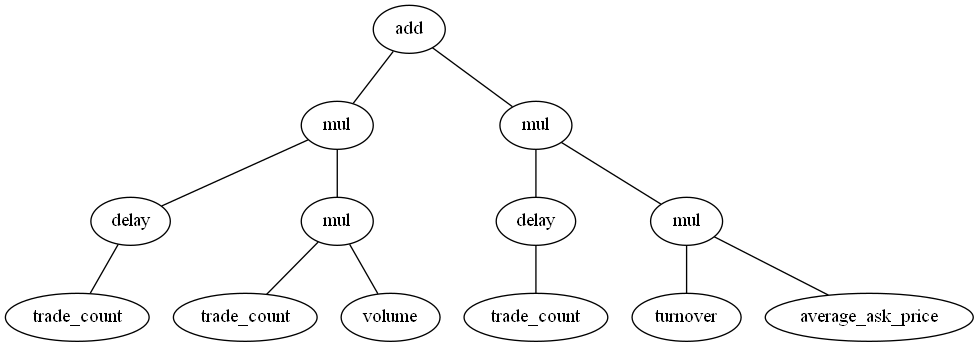

In [40]:
stdbest0 = hof_std[0]
rename_labels = {'and_': '&', 'or_': '|', 'not_': '~'}   # we want use symbol labels instead of words in the tree graph
gep.export_expression_tree(stdbest0, rename_labels, 'data/bool_tree.png')
# show the above image here for convenience
from IPython.display import Image
Image(filename='data/bool_tree.png')

·观察公式的结果，量纲还是不太对应

·如何筛选因子，怎样从量纲层面筛选因子（怎样确定一个因子是合理的）

# 因子统计分析

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats.mstats import winsorize
func = toolbox.compile(stdbest0)
factor = list(func(X_std['high'],X_std['low'],X_std['open'],X_std['last_price'],X_std['volume'],X_std['turnover'],
               X_std['trade_count'],X_std['previous_close'],X_std['high_limit'],X_std['low_limit'],X_std['total_volume'],
               X_std['total_value'],X_std['average_ask_price'],X_std['average_bid_price']))
factor_win = winsorize(factor, limits=[0.01,0.05])
X['factor'] = factor_win
X_std1 = X.apply(lambda x: (x - np.mean(x)) / np.std(x))
pd.Series(factor_win).describe()

count    513000.000000
mean         -0.000928
std           0.048098
min          -0.090528
25%          -0.028974
50%           0.002948
75%           0.024967
max           0.091094
dtype: float64

<AxesSubplot:xlabel='factor', ylabel='Density'>

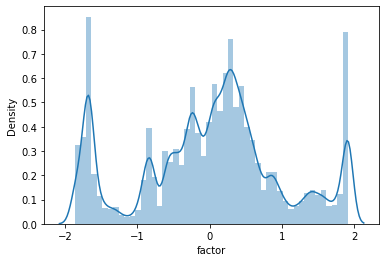

In [14]:
sns.distplot(pd.Series(X_std1['factor']))

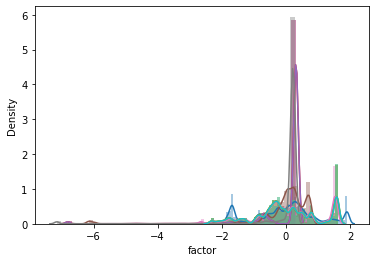

In [15]:
for stdbest in hof_std:
    func = toolbox.compile(stdbest)
    factor = list(func(X_std['high'],X_std['low'],X_std['open'],X_std['last_price'],X_std['volume'],X_std['turnover'],
                   X_std['trade_count'],X_std['previous_close'],X_std['high_limit'],X_std['low_limit'],X_std['total_volume'],
                   X_std['total_value'],X_std['average_ask_price'],X_std['average_bid_price']))
    factor_win = winsorize(factor, limits=[0.01,0.05])
    X['factor'] = factor_win
    X_std1 = X.apply(lambda x: (x - np.mean(x)) / np.std(x))
    sns.distplot(pd.Series(X_std1['factor']))

# 从标准化因子后的结果来看，中间和两边分布比较多，如何衡量因子好坏！

# 下一步工作推进

1.寻找因子统计的方法筛选因子

2.添加函数部分，同时想办法加速函数运行，提升效率

从树产生因子公式，写时序回测函数
因子公式+回测指标+输出表格，因子分布输出图片
时序性交叉验证（rolling CV）
去掉’total_value'再计算一次